In [61]:
import numpy as np
import pandas as pd
from model.autoencoder import AutoEncoder
from model.vae import aligned_vae, vae
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import diffusion_dist as diff
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from dataset import *
import scipy
import math

In [ ]:
pd_atac = pd.read_csv('./data/expr_atac_processed.csv', index_col=0)
pd_rna = pd.read_csv('./data/expr_rna_processed.csv', index_col=0)
atac = pd_atac.to_numpy()
rna = pd_rna.to_numpy()

In [2]:
atac = torch.FloatTensor(np.tile(np.arange(100), (100, 1)) + np.tile(np.arange(100)[:,None], 100))
rna = torch.FloatTensor(np.tile(np.arange(200), (100, 1)) + np.tile(np.arange(100)[:,None], 200))

In [ ]:
atac

In [ ]:
rna

In [3]:
def pairwise_distance(x):
    x_norm = (x**2).sum(1).view(-1, 1)
    y_norm = x_norm.view(1, -1)
    dist = x_norm + y_norm - 2.0 * torch.mm(x, torch.transpose(x, 0, 1))
    return dist 

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = scDataset(dim_reduction=False)
testset = testDataset()

# Similarity matrix
Note that for distance calculation, dimension reduction is necessary as raw data is too noisy
## Diffusion map distance

In [5]:
pca = PCA(n_components=30)

# atac_lsi = latent_semantic_indexing(atac, k = 30)
atac_pca = pca.fit_transform(atac)

rna_pca = pca.fit_transform(np.log1p(rna))

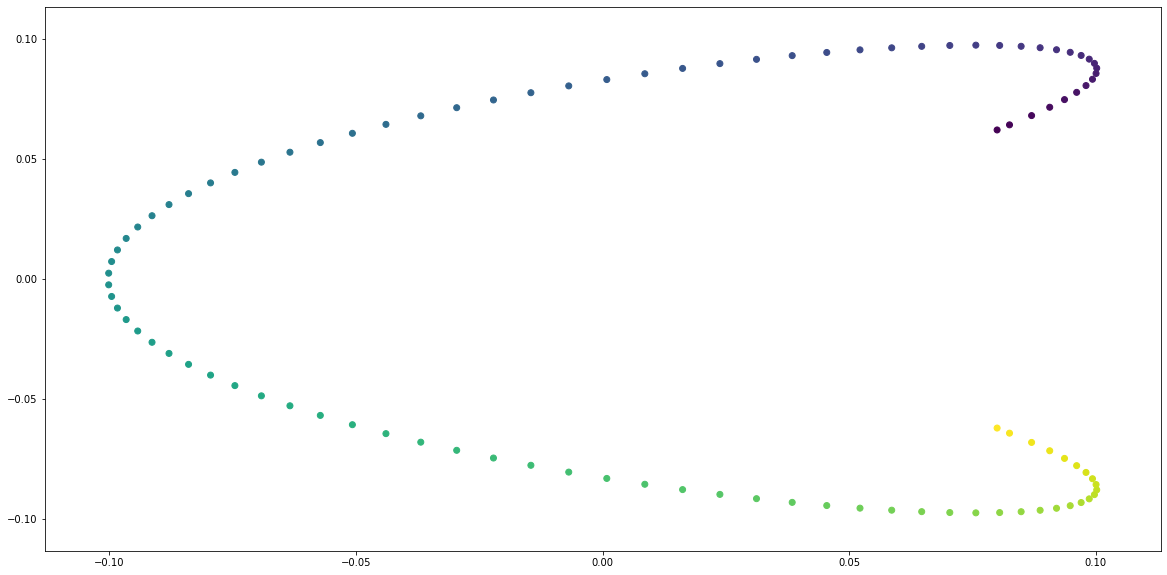

In [6]:
diffu_atac = diff.diffusion_map(atac_pca, n_eign = 10, alpha = 100, diffusion_time = 5)
diff_sim_atac = diff.diffusion_similarity(diffu_atac)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(diffu_atac[:,2], diffu_atac[:,1], c=np.arange(atac.shape[0]))

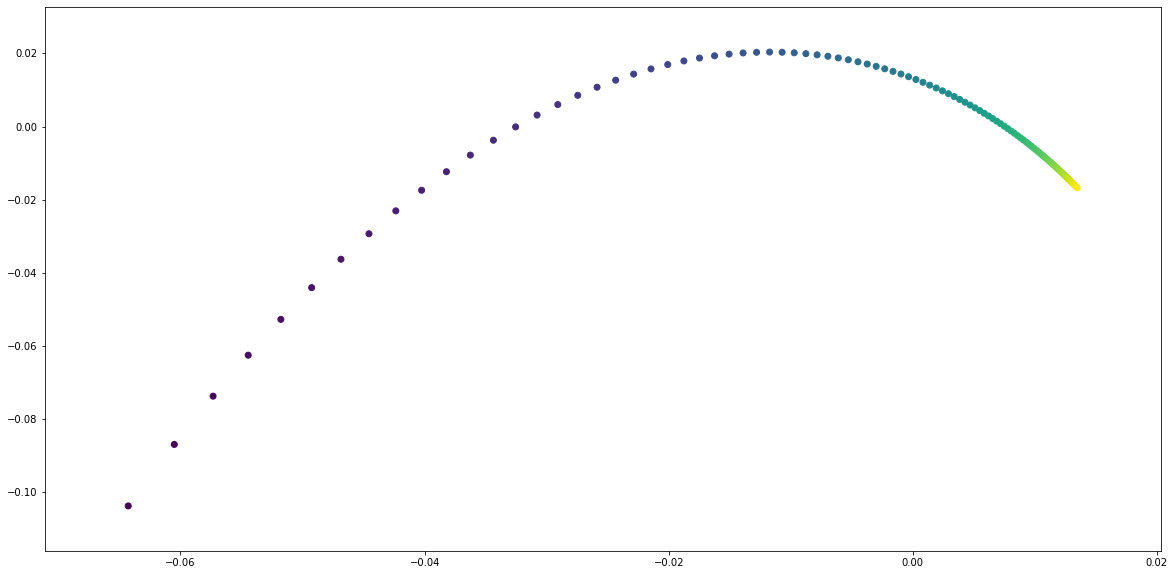

In [7]:
diffu = diff.diffusion_map(rna_pca, n_eign = 10, alpha = 15, diffusion_time = 5)
diff_sim_rna = diff.diffusion_similarity(diffu)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(diffu[:,1], diffu[:,2], c=np.arange(rna.shape[0]))


In [8]:
# normalize both matrices for inner product loss
diff_sim_atac = torch.FloatTensor(diff_sim_atac).to(device)
diff_sim_rna = torch.FloatTensor(diff_sim_rna).to(device)
diff_sim_atac = diff_sim_atac / torch.norm(diff_sim_atac, p = 'fro')
diff_sim_rna = diff_sim_rna / torch.norm(diff_sim_rna, p = 'fro')

In [9]:
# pca calculated internally, no need to do pca before
DPT_atac = diff.DPT_similarity(atac)
DPT_rna = diff.DPT_similarity(rna)

# normalize both matrices for inner product loss
DPT_atac = torch.FloatTensor(DPT_atac).to(device)
DPT_rna = torch.FloatTensor(DPT_rna).to(device)
DPT_atac = DPT_atac / torch.norm(DPT_atac, p = 'fro')
DPT_rna = DPT_rna / torch.norm(DPT_rna, p = 'fro')

In [10]:
def dist_loss(recon_atac, recon_rna, atac, rna, z, diff_atac, diff_rna, lamb, lamb_var, dist_loss_type = "cosine"):
    loss_recon_rna = F.mse_loss(recon_rna, rna)
    loss_recon_atac = F.mse_loss(recon_atac, atac)

    # loss_variance = - lamb_var * (torch.sum((z[:,0] - torch.mean(z[:,0])) ** 2) + torch.sum((z[:,1] - torch.mean(z[:,1])) ** 2))

    # cosine similarity loss, don't forget to normalize the matrix before calculate inner product
    if dist_loss_type == "cosine":
        # diff_atac and diff_rna are only constant, but better to be normalized
        Sim = pairwise_distance(z)
        # normalize latent similarity matrix
        Sim = Sim / torch.norm(Sim, p='fro')

        # inner product loss, maximize, so add negative before, in addition, make sure those two values are normalized, with norm 1
        loss_dist_atac = - lamb * torch.sum(diff_atac * Sim)
        loss_dist_rna = - lamb * torch.sum(diff_rna * Sim)

    # pearson correlationship
    elif dist_loss_type == "pearson":
        Sim = pairwise_distance(z)
        Vs = Sim - torch.mean(Sim)

        Vd_atac = diff_atac - torch.mean(diff_atac)
        Vd_rna = diff_rna - torch.mean(diff_rna)

        # maximize correlationship
        loss_dist_atac = - lamb * torch.sum(Vs * Vd_atac) / (torch.sqrt(torch.sum(Vs ** 2)) * torch.sqrt(torch.sum(Vd_atac ** 2)))
        loss_dist_rna = - lamb * torch.sum(Vs * Vd_rna) / (torch.sqrt(torch.sum(Vs ** 2)) * torch.sqrt(torch.sum(Vd_rna ** 2)))
    
    # mse loss
    elif dist_loss_type == "mse":
        loss_dist_atac = lamb * F.mse_loss(diff_atac.reshape(-1), pairwise_distance(z).reshape(-1))
        loss_dist_rna = lamb * F.mse_loss(diff_rna.reshape(-1), pairwise_distance(z).reshape(-1))

    loss = loss_recon_rna + loss_recon_atac + loss_dist_atac + loss_dist_rna
    return loss, loss_recon_rna, loss_recon_atac,  loss_dist_atac,  loss_dist_rna

In [63]:
def train_ae(model, data_loader, lamb = 10, lamb_var = 0.1, similarity = "DPT"):
    model.train()

    total_loss = 0
    total_loss_recon_rna = total_loss_recon_atac = 0
    total_loss_dist_atac = total_loss_dist_rna = 0
    total_loss_var = 0
    for data in data_loader:
        optimizer.zero_grad()
        batch_atac = data['ATAC'].to(device)
        batch_rna = data['RNA'].to(device)
        recon_atac, recon_rna, z = model(batch_atac, batch_rna)

        if similarity == "DPT":
            batch_diff_atac = DPT_atac[data['index'], :][:, data['index']]
            batch_diff_rna = DPT_rna[data['index'], :][:, data['index']]           
        elif similarity == "diffusion map":
            batch_diff_atac = diff_sim_atac[data['index'], :][:, data['index']]
            batch_diff_rna = diff_sim_rna[data['index'], :][:, data['index']]

        loss = dist_loss(recon_atac, recon_rna, batch_atac, batch_rna, z, batch_diff_atac, batch_diff_rna, lamb = lamb, lamb_var = lamb_var, dist_loss_type= 'cosine')
        total_loss += loss[0]
        total_loss_recon_rna += loss[1]
        total_loss_recon_atac += loss[2]
        total_loss_dist_rna += loss[3]
        total_loss_dist_atac += loss[4]

        current_loss = loss[1] + loss[2]
        current_loss.backward()
        optimizer.step()

    return total_loss.item() / len(data_loader), total_loss_recon_rna.item() / len(data_loader), total_loss_recon_atac.item() / len(data_loader), \
 total_loss_dist_rna.item() / len(data_loader), total_loss_dist_atac.item() / len(data_loader)

In [68]:
def test(model):
    data_loader_test = DataLoader(testset, batch_size=len(testset),shuffle=False)
    for data in data_loader_test:
        recon_atac, recon_rna, z = model(torch.FloatTensor(data['ATAC']).to(device), data['RNA'].to(device))
    z = z.detach().cpu().numpy()
    atac_loss = F.mse_loss(torch.FloatTensor(atac).to(device), recon_atac).item()
    rna_loss = F.mse_loss(torch.FloatTensor(rna).to(device), recon_rna).item()
    return z, atac_loss, rna_loss, recon_atac, recon_rna

## AutoEncoder
Diffusion map as similarity matrix

In [66]:
data_loader = DataLoader(testset, shuffle=True, batch_size=32)

model_ae = AutoEncoder(in_channels_atac=atac.shape[1], in_channels_rna=rna.shape[1], latent_channels_atac=32, latent_channels_rna=32, latent_channels_z=2, layer1_channels = 512, layer2_channels = 128).to(device)
optimizer = torch.optim.Adam(model_ae.parameters(), lr=5e-4, weight_decay=0.01)

for epoch in range(0, 301):

    loss, l1, l2, l3, l4 = train_ae(model_ae, data_loader, lamb = 100, similarity = "diffusion map")
    if epoch % 10 == 0:
        log = "Epoch: {:03d}, Total loss: {:.5f}, Recon RNA loss: {:.5f}, Recon ATAC loss {:.5f}, Dist RNA loss {:.5f}, Dist ATAC loss {:.5f}"
        print(log.format(epoch, loss, l1, l2, l3, l4))

Epoch: 000, Total loss: 39460.01953, Recon RNA loss: 27357.91992, Recon ATAC loss 12135.81348, Dist RNA loss -17.15030, Dist ATAC loss -16.56390
Epoch: 010, Total loss: 1175.99146, Recon RNA loss: 915.08716, Recon ATAC loss 295.60901, Dist RNA loss -17.04100, Dist ATAC loss -17.66370
Epoch: 020, Total loss: 176.70995, Recon RNA loss: 139.42134, Recon ATAC loss 71.89180, Dist RNA loss -17.07963, Dist ATAC loss -17.52356
Epoch: 030, Total loss: 260.93512, Recon RNA loss: 181.47681, Recon ATAC loss 113.66895, Dist RNA loss -17.10333, Dist ATAC loss -17.10733
Epoch: 040, Total loss: 206.57748, Recon RNA loss: 134.96751, Recon ATAC loss 106.79519, Dist RNA loss -17.12187, Dist ATAC loss -18.06333
Epoch: 050, Total loss: 227.46307, Recon RNA loss: 138.90639, Recon ATAC loss 123.48867, Dist RNA loss -17.23787, Dist ATAC loss -17.69413
Epoch: 060, Total loss: 196.89775, Recon RNA loss: 122.84637, Recon ATAC loss 109.29587, Dist RNA loss -17.28005, Dist ATAC loss -17.96443
Epoch: 070, Total los

atac recon loss:0.008145399391651154rna recon loss0.004323887638747692


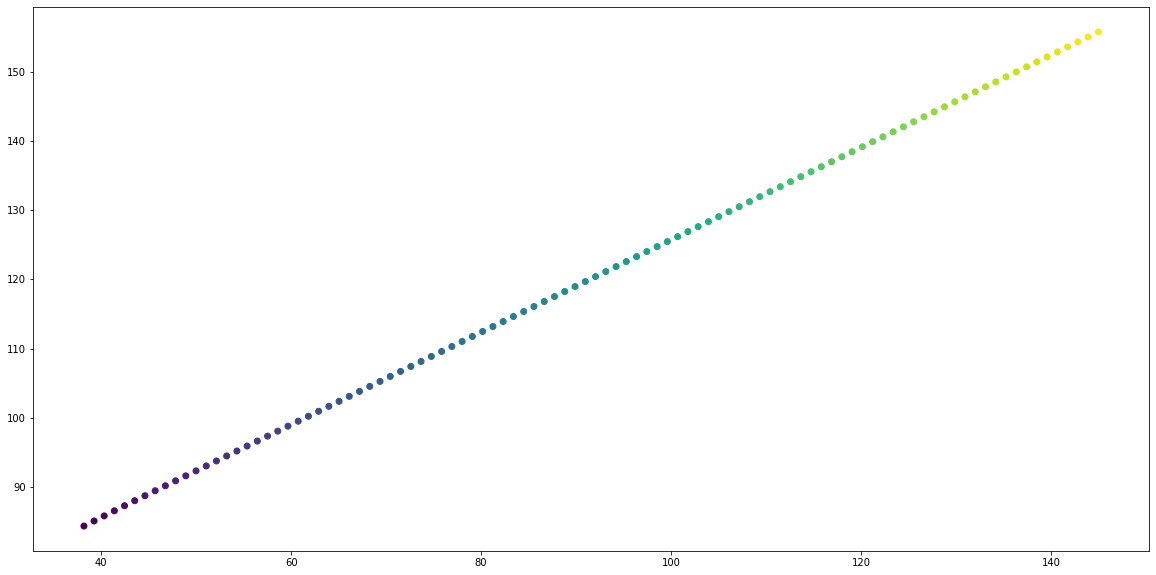

In [69]:
z, atac_loss, rna_loss, recon_atac, recon_rna = test(model_ae)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(z[:,0], z[:,1], c=np.arange(rna.shape[0]))
print("atac recon loss: ", atac_loss, "rna recon loss", rna_loss)

In [71]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(rna.detach().cpu().numpy(), recon_rna.detach().cpu().numpy()))
print(mean_squared_error(atac.detach().cpu().numpy(), recon_atac.detach().cpu().numpy()))

0.004323888
0.0081454


DPT as similarity matrix

In [ ]:
data_loader = DataLoader(dataset, shuffle=True, batch_size=32)

model_ae = AutoEncoder(in_channels_atac=atac.shape[1], in_channels_rna=rna.shape[1], latent_channels_atac=16, latent_channels_rna=16, latent_channels_z=2, layer1_channels = 512, layer2_channels = 128).to(device)
optimizer = torch.optim.Adam(model_ae.parameters(), lr=1e-4, weight_decay=0.01)

for epoch in range(0, 30):

    loss, l1, l2, l3, l4 = train_ae(model_ae, lamb = 100, similarity = "DPT")
    if epoch % 10 == 0:
        log = "Epoch: {:03d}, Total loss: {:.5f}, Recon RNA loss: {:.5f}, Recon ATAC loss {:.5f}, Dist RNA loss {:.5f}, Dist ATAC loss {:.5f}"
        print(log.format(epoch, loss, l1, l2, l3, l4))

In [ ]:
z, l1, l2 = test(model_ae)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(z[:,0], z[:,1], c=np.arange(rna.shape[0]))
print("atac recon loss: ", l1, "rna recon loss", l2)

## Variational AutoEncoder

In [77]:
def dist_loss_kl(recon_atac, recon_rna, atac, rna, z, diff_atac, diff_rna, logvarz, muz, lamb, dist_loss_type = "cosine", beta=0.01):
    loss_recon_rna = F.mse_loss(rna, recon_rna)
    loss_recon_atac = F.mse_loss(atac, recon_atac)

    # cosine similarity loss, don't forget to normalize the matrix before calculate inner product
    if dist_loss_type == "cosine":
        # diff_atac and diff_rna are only constant, but better to be normalized
        Sim = pairwise_distance(z)
        # normalize latent similarity matrix
        Sim = Sim / torch.norm(Sim, p='fro')

        # inner product loss, maximize, so add negative before, in addition, make sure those two values are normalized, with norm 1
        loss_dist_atac = - lamb * torch.sum(diff_atac * Sim)
        loss_dist_rna = - lamb * torch.sum(diff_rna * Sim)

    # pearson correlationship
    elif dist_loss_type == "pearson":
        Sim = pairwise_distance(z)
        Vs = Sim - torch.mean(Sim)

        Vd_atac = diff_atac - torch.mean(diff_atac)
        Vd_rna = diff_rna - torch.mean(diff_rna)

        # maximize correlationship
        loss_dist_atac = - lamb * torch.sum(Vs * Vd_atac) / (torch.sqrt(torch.sum(Vs ** 2)) * torch.sqrt(torch.sum(Vd_atac ** 2)))
        loss_dist_rna = - lamb * torch.sum(Vs * Vd_rna) / (torch.sqrt(torch.sum(Vs ** 2)) * torch.sqrt(torch.sum(Vd_rna ** 2)))
    
    # mse loss
    elif dist_loss_type == "mse":
        loss_dist_atac = lamb * F.mse_loss(diff_atac.reshape(-1), pairwise_distance(z).reshape(-1))
        loss_dist_rna = lamb * F.mse_loss(diff_rna.reshape(-1), pairwise_distance(z).reshape(-1))

    loss_kl = beta * 0.5 * torch.sum(- logvarz + torch.exp(logvarz) + muz * muz - 1)

    loss = loss_recon_rna + loss_recon_atac + loss_dist_atac + loss_dist_rna + loss_kl
    return loss, loss_recon_rna, loss_recon_atac,  loss_dist_atac,  loss_dist_rna, loss_kl

In [95]:
def train_vae(model, data_loader, lamb = 1, beta = 0.01, similarity = "DPT"):
    model.train()

    total_loss = 0
    total_loss_recon_rna = total_loss_recon_atac = 0
    total_loss_dist_atac = total_loss_dist_rna = 0
    total_loss_kl = 0
    for data in data_loader:
        optimizer.zero_grad()
        batch_atac = data['ATAC'].to(device)
        batch_rna = data['RNA'].to(device)
        recon_atac, recon_rna, z, logvarz, muz = model(batch_atac, batch_rna)

        if similarity == "DPT":
            batch_diff_atac = DPT_atac[data['index'], :][:, data['index']]
            batch_diff_rna = DPT_rna[data['index'], :][:, data['index']]           
        elif similarity == "diffusion map":
            batch_diff_atac = diff_sim_atac[data['index'], :][:, data['index']]
            batch_diff_rna = diff_sim_rna[data['index'], :][:, data['index']]

        loss = dist_loss_kl(recon_atac, recon_rna, batch_atac, batch_rna, z, batch_diff_atac, batch_diff_rna, logvarz, muz, lamb = lamb, dist_loss_type= 'cosine', beta = beta)
        total_loss += loss[0]
        total_loss_recon_rna += loss[1]
        total_loss_recon_atac += loss[2]
        total_loss_dist_rna += loss[3]
        total_loss_dist_atac += loss[4]
        total_loss_kl += loss[5]

        current_loss = loss[1] + loss[2] + loss[5]
        current_loss.backward()
        optimizer.step()
    
    return total_loss.item() / len(data_loader), total_loss_recon_rna.item() / len(data_loader), total_loss_recon_atac.item() / len(data_loader), \
 total_loss_dist_rna.item() / len(data_loader), total_loss_dist_atac.item() / len(data_loader), total_loss_kl / len(data_loader)

In [103]:
def test_vae(model):
    model.eval()
    
    data_loader_test = DataLoader(testset, batch_size=len(dataset),shuffle=False)
    for data in data_loader_test:
        recon_atac, recon_rna, z, logvarz, muz = model(torch.FloatTensor(data['ATAC']).to(device), data['RNA'].to(device))
    z = z.detach().cpu().numpy()
    muz = muz.detach().cpu().numpy()
    logvarz = logvarz.detach().cpu().numpy()
    atac_loss = F.mse_loss(torch.FloatTensor(atac).to(device), recon_atac).item()
    rna_loss = F.mse_loss(torch.FloatTensor(rna).to(device), recon_rna).item()

    return z, atac_loss, rna_loss, recon_atac, recon_rna, logvarz, muz

In [101]:
data_loader = DataLoader(testset, shuffle=True, batch_size=32)

model_vae = aligned_vae(in_channels_atac=atac.shape[1], in_channels_rna=rna.shape[1], latent_channels_atac=32, latent_channels_rna=32, latent_channels_z=2).to(device)
optimizer = torch.optim.Adam(model_vae.parameters(), lr=1e-3, weight_decay=0.01)

for epoch in range(0, 401):

    loss, l1, l2, l3, l4, l5 = train_vae(model_vae, data_loader, lamb = 100, beta=0.01, similarity = "DPT")
    if epoch % 20 == 0:
        log = "Epoch: {:03d}, Total loss: {:.5f}, Recon RNA loss: {:.5f}, Recon ATAC loss {:.5f}, Dist RNA loss {:.5f}, Dist ATAC loss {:.5f}, KL loss: {:.5f}"
        print(log.format(epoch, loss, l1, l2, l3, l4, l5))

Epoch: 000, Total loss: 46099.48828, Recon RNA loss: 25420.26562, Recon ATAC loss 10887.32031, Dist RNA loss -11.82758, Dist ATAC loss -11.82758, KL loss: 9815.55859
Epoch: 020, Total loss: 1115.46570, Recon RNA loss: 169.10725, Recon ATAC loss 122.61427, Dist RNA loss -23.10639, Dist ATAC loss -23.10639, KL loss: 869.95703
Epoch: 040, Total loss: 614.33813, Recon RNA loss: 123.23976, Recon ATAC loss 118.51608, Dist RNA loss -22.63029, Dist ATAC loss -22.63029, KL loss: 417.84293
Epoch: 060, Total loss: 440.96832, Recon RNA loss: 127.20855, Recon ATAC loss 109.03169, Dist RNA loss -22.80763, Dist ATAC loss -22.80763, KL loss: 250.34334
Epoch: 080, Total loss: 323.65085, Recon RNA loss: 114.31750, Recon ATAC loss 90.47856, Dist RNA loss -22.15926, Dist ATAC loss -22.15926, KL loss: 163.17328
Epoch: 100, Total loss: 217.10733, Recon RNA loss: 91.41819, Recon ATAC loss 51.60835, Dist RNA loss -22.89687, Dist ATAC loss -22.89687, KL loss: 119.87453
Epoch: 120, Total loss: 137.84790, Recon 

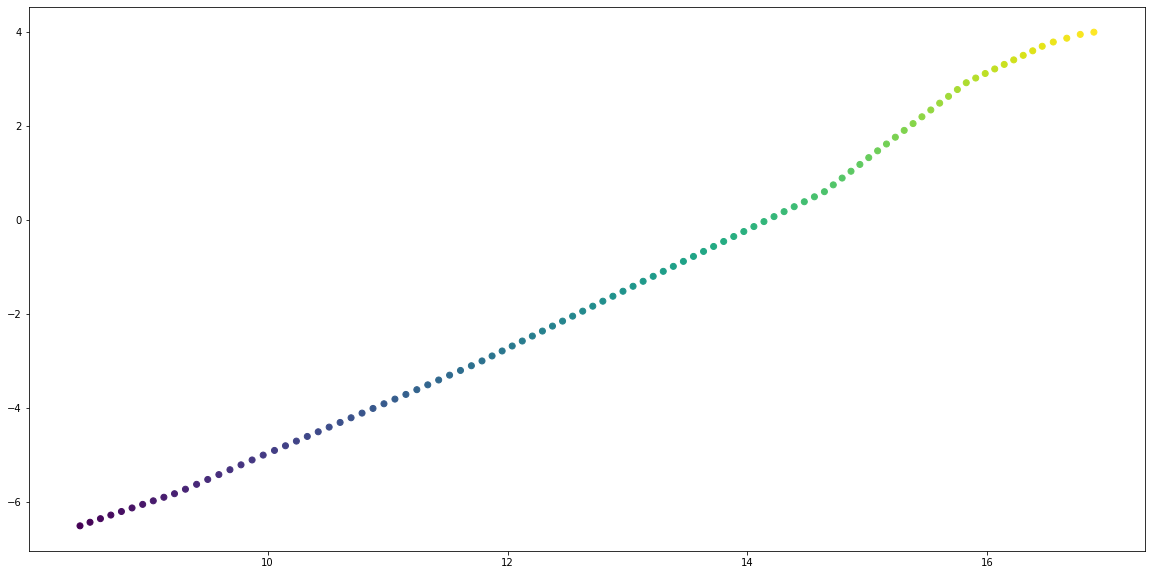

In [104]:
z, _, _, recon_atac, recon_rna, logvarz, muz = test_vae(model_vae)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(z[:,0], z[:,1], c=np.arange(rna.shape[0]))

In [107]:
recon_atac

tensor([[  0.6122,   1.5997,   2.6884,  ...,  97.2250,  98.2305,  99.4457],
        [  1.3986,   2.3819,   3.4767,  ...,  98.0635,  99.0672, 100.2695],
        [  2.2017,   3.1809,   4.2821,  ...,  98.9354,  99.9372, 101.1267],
        ...,
        [ 95.7917,  96.7696,  97.8524,  ..., 193.2700, 194.2248, 195.3523],
        [ 96.7230,  97.7028,  98.7944,  ..., 194.6296, 195.5885, 196.7222],
        [ 97.4853,  98.4694,  99.5701,  ..., 195.9686, 196.9339, 198.0733]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [106]:
recon_rna

tensor([[  0.9144,   1.8438,   2.7504,  ..., 196.7913, 197.9169, 199.0358],
        [  1.6672,   2.6062,   3.5171,  ..., 197.6949, 198.8107, 199.9323],
        [  2.4360,   3.3848,   4.3003,  ..., 198.6466, 199.7526, 200.8770],
        ...,
        [ 95.7977,  96.7500,  97.7102,  ..., 293.0020, 293.9750, 295.0509],
        [ 96.7223,  97.6775,  98.6393,  ..., 294.6998, 295.6783, 296.7588],
        [ 97.4721,  98.4326,  99.3991,  ..., 296.5207, 297.5051, 298.5921]],
       device='cuda:0', grad_fn=<AddmmBackward>)